## Setting up packages and clean dataset

In [ ]:
# Final Model, Visuals, and Evaluation

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

from sklearn.model_selection import train_test_split

df = pd.read_csv('CDC-2019-2021-2023-DATA.csv')

df = df[df['IYEAR'] != 2024]


# Cleaning the target variable
df.ADDEPEV3 = df['ADDEPEV3'].replace({'Yes':1,'No':0}).astype(float)

if "MENTHLTH" in df.columns:
    df["MENTHLTH"] = df["MENTHLTH"].replace({88: 0, 77: np.nan, 99: np.nan})

if "POORHLTH" in df.columns:
    df["POORHLTH"] = df["POORHLTH"].replace({88: 0, 77: np.nan, 99: np.nan})

df = df.dropna()


C:\Users\User\AppData\Local\Temp\ipykernel_16360\1769652360.py:12: DtypeWarning: Columns (1,4,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('CDC-2019-2021-2023-DATA.csv')


We loaded combined BRFSS dataset, removed 20024 responses, converted depression diagnosis variable (ADDEPEV3) into a bionary 0/1 response so the logistic regression can be properly trained. Numeric mental-health vairables of MENTHLTH and POORHLTH have codes 88, 77, and 99 to represent non-responses so these are recoded as valid "0 days" for 88 and 77 and 99 as missing values. Finally, any row with a missing value is dropped to ensure the logistic regression is trained only on complete and interpretable observations.

### Exploring variables and assumptions

In [34]:

print(df['ADDEPEV3'].value_counts())
print(df.head())


ADDEPEV3
0.0    1009829
1.0     247883
Name: count, dtype: int64
   Unnamed: 0 BIRTHSEX  MENTHLTH  POORHLTH  ADDEPEV3 DECIDE DIFFALON ACEDEPRS  \
0           0      NaN       0.0       0.0       0.0     No       No       No   
1           1      NaN       0.0      10.0       0.0     No       No       No   
2           2      NaN      30.0       0.0       0.0     No       No       No   
3           3      NaN       0.0       0.0       0.0     No      NaN      NaN   
4           4      NaN       0.0       NaN       0.0     No       No       No   

  ACEDRINK ACEDRUGS ACEPRISN ACEDIVRC ACEPUNCH        ACEHURT1  \
0       No       No       No      Yes    Never  More than once   
1      Yes       No       No       No    Never            Once   
2       No       No       No       No      NaN           Never   
3      NaN      NaN      NaN      NaN      NaN             NaN   
4       No       No       No       No    Never           Never   

         ACESWEAR ACETOUCH ACETTHEM ACEHVSEX  IYEAR

In [36]:

# Separating target variable and predictors

y = df['ADDEPEV3']
X = df[['BIRTHSEX', 'MENTHLTH', 'POORHLTH',
         'DECIDE', 'DIFFALON', 'IYEAR', 
        'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS','ACEPRISN', 
        'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR',
        'ACETOUCH','ACETTHEM', 'ACEHVSEX']]

# Separating numeric and categorical variables

nums = ['POORHLTH', 'MENTHLTH']
cats = ['IYEAR', 'BIRTHSEX', 'ACEDEPRS', 
        'DECIDE', 'DIFFALON', 'ACEDRINK', 
        'ACEDRUGS','ACEPRISN', 'ACEDIVRC', 
        'ACEPUNCH', 'ACEHURT1', 'ACESWEAR',
        'ACETOUCH','ACETTHEM', 'ACEHVSEX']


for c in cats:
    print(df[c].value_counts())



IYEAR
2023    9322
2021    3652
2019    2816
Name: count, dtype: int64
BIRTHSEX
Female    9138
Male      6652
Name: count, dtype: int64
ACEDEPRS
No     11815
Yes     3975
Name: count, dtype: int64
DECIDE
No     13135
Yes     2655
Name: count, dtype: int64
DIFFALON
No     13947
Yes     1843
Name: count, dtype: int64
ACEDRINK
No     11396
Yes     4394
Name: count, dtype: int64
ACEDRUGS
No     13693
Yes     2097
Name: count, dtype: int64
ACEPRISN
No     14307
Yes     1483
Name: count, dtype: int64
ACEDIVRC
No                     11059
Yes                     4459
Parents not married      272
Name: count, dtype: int64
ACEPUNCH
Never             12761
More than once     2241
Once                788
Name: count, dtype: int64
ACEHURT1
Never             11211
More than once     3342
Once               1237
Name: count, dtype: int64
ACESWEAR
Never             9277
More than once    5508
Once              1005
Name: count, dtype: int64
ACETOUCH
Never             13528
More than once     1444
Onc

In [37]:

df.dtypes


Unnamed: 0      int64
BIRTHSEX       object
MENTHLTH      float64
POORHLTH      float64
ADDEPEV3      float64
DECIDE         object
DIFFALON       object
ACEDEPRS       object
ACEDRINK       object
ACEDRUGS       object
ACEPRISN       object
ACEDIVRC       object
ACEPUNCH       object
ACEHURT1       object
ACESWEAR       object
ACETOUCH       object
ACETTHEM       object
ACEHVSEX       object
IYEAR           int64
dtype: object

Here, demographic, physical-health, and adverse childhood experiences (ACE) are selected as predictors for the target variable of depression diagnosis (ADDEPEV3).

In [38]:
# assumptions check 
print(df[["MENTHLTH", "POORHLTH"]].corr())
print(df[["MENTHLTH", "ADDEPEV3"]].corr())


          MENTHLTH  POORHLTH
MENTHLTH  1.000000  0.339434
POORHLTH  0.339434  1.000000
          MENTHLTH  ADDEPEV3
MENTHLTH  1.000000  0.380646
ADDEPEV3  0.380646  1.000000


c:\Users\User\anaconda3\envs\ds6001\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


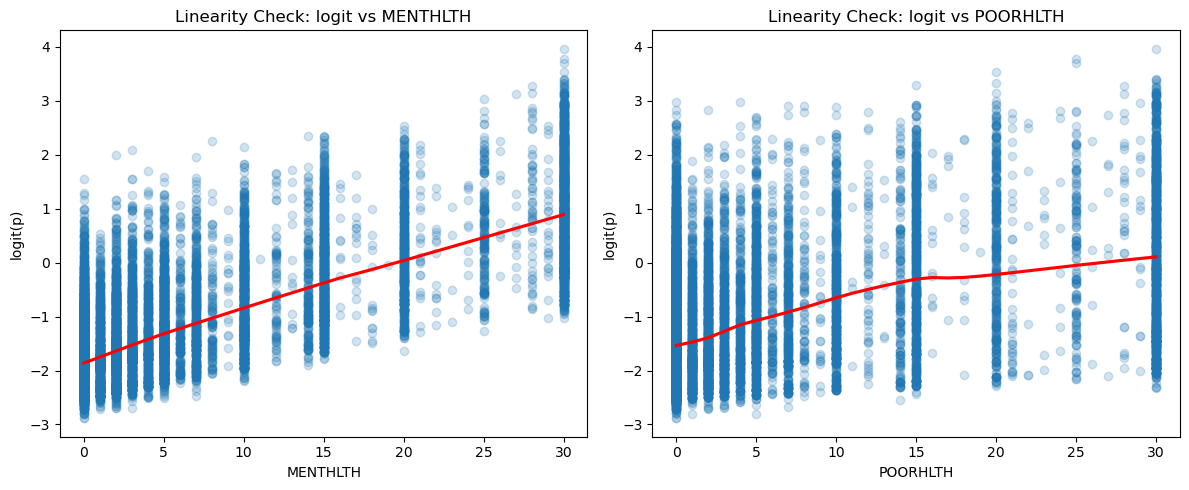

In [ ]:
# assumption check: Linearity of the logit for numeric variables
import seaborn as sns
import matplotlib.pyplot as plt



preprocess = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first'), cats),
        ('numeric', 'passthrough', nums)
    ]
)

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression())
])
pipe.fit(X=X, y=y)


# 1. Get predicted probabilities from your fitted pipeline
p = pipe.predict_proba(X)[:, 1]

# 2. Compute the logit (log-odds)
df["logit"] = np.log(p / (1 - p))

# 3. Check linearity for numeric variables
numeric_vars = ["MENTHLTH", "POORHLTH"]

plt.figure(figsize=(12, 5))

for i, var in enumerate(numeric_vars):
    plt.subplot(1, 2, i + 1)
    sns.regplot(x=df[var], y=df["logit"], lowess=True,
                scatter_kws={"alpha": 0.2}, line_kws={"color": "red"})
    plt.title(f"Linearity Check: logit vs {var}")
    plt.xlabel(var)
    plt.ylabel("logit(p)")

plt.tight_layout()
plt.show()



This verfies that numeric predictors MENTHLTH and POORHLTH are not excessively correleted; we assess linearity of the logit by plotting log-odds agaisnt those numeric variables. The pattern doesn't violate logistic regression assumptions so we continue to fit the model. 

## Fit final Logistic Regression Model

In [40]:

# Final fit of logistic regression model

preprocess = ColumnTransformer(transformers=[('encoder',OneHotEncoder(drop='first', handle_unknown = 'ignore'),cats),
                                             ('numeric','passthrough',nums)])


pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=2000))
])
pipe.fit(X=X,y=y)

# Predicting probabilities and setting cutoff for what is classified as a yes versus a no

p = pipe.predict_proba(X)[:,1]
y_hat = (p >= 0.5).astype(int)

# Outputting the actual, predicted probability, and predicted label of depression

results = pd.DataFrame({
    "Actual Depressed": y,
    "Predicted Prob Depressed": p.round(3),
    "Predicted Label": y_hat
})
results


,Actual Depressed,Predicted Prob Depressed,Predicted Label
309121,0.0,0.098,0
309123,0.0,0.087,0
309124,0.0,0.116,0
309126,0.0,0.197,0
309133,0.0,0.157,0
...,...,...,...
1196881,1.0,0.693,1
1197286,1.0,0.830,1
1197605,0.0,0.721,1
1197633,0.0,0.337,0


These are in-sample predictions to see if the logistic regression model is functioning correctly before performing evaluations. This table displays a person's actual depression status, the model-estimated probability of depression, and the predicted classification using a 0.5 threshold. Essentially, this helps us see that our model sensibly estimates higher probabilities for individuals who are actually depresed. 

## Model Evaluatiom

In [41]:
# Calculate and Output the Accuracy Score and Log Loss
acc = accuracy_score(y,y_hat)
ll = log_loss(y,p)

print(f'Accuracy: {str(acc)}')
print(f'Log Loss: {str(ll)}')

Accuracy: 0.7742875237492084
Log Loss: 0.4817783662624926


In [42]:
# Upgraded evaluation 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
y_prob = pipe.predict_proba(X_test)[:,1]
y_hat = (y_prob >= 0.5).astype(int)


In [ ]:
# Metrics on the TEST set
test_acc = accuracy_score(y_test, y_hat)
test_ll  = log_loss(y_test, y_prob)

print(f"Test accuracy: {test_acc:.3f}")
print(f"Test log loss: {test_ll:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_hat)
print("\nConfusion matrix (test set):\n", cm)

# More detailed classification summary
print("\nClassification report (test set):\n")
print(classification_report(y_test, y_hat, digits=3))


Test accuracy: 0.770
Test log loss: 0.491

Confusion matrix (test set):
 [[3100  264]
 [ 827  546]]

Classification report (test set):

              precision    recall  f1-score   support

         0.0      0.789     0.922     0.850      3364
         1.0      0.674     0.398     0.500      1373

    accuracy                          0.770      4737
   macro avg      0.732     0.660     0.675      4737
weighted avg      0.756     0.770     0.749      4737



Our logistic regression shows strong predictive performance for predicting depression based on mental-health, adverse childhood experiences, and demographic factors. On the held-out test set, the model achieves 77% accuracy and a log loss of 0.491, indicating reasonable probability estimates. The confusion matrix and classification report show that the model performs very well for the majority class (not depressed), with a recall of 0.922 and F! of 0.850, again, showing it's correct identification of most respondents that are not depressed. Performance on the minority class, those that are depressed, is weaker but still meaningful, with precision of 0.674, recall of 0.398,and F1 of 0.500. Given the class imbalance and complexity of mental-health prediction generally, this pattern is expected. 

Test AUC: 0.788


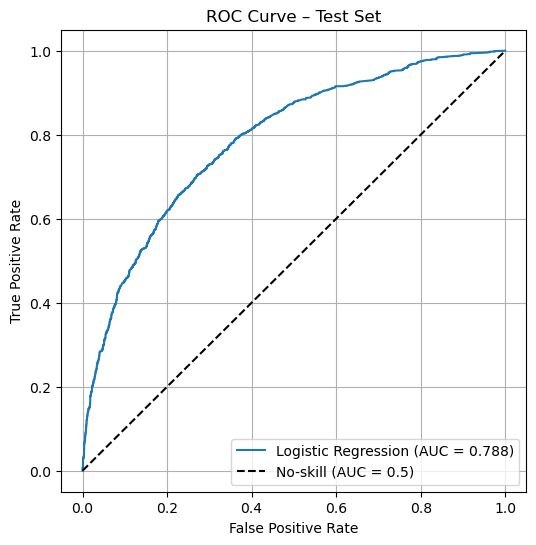

In [44]:
# --- ROC curve + AUC on the TEST set ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC: {auc:.3f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="No-skill (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test Set")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validated AUC on the full dataset (refits pipe each fold)
cv_auc = cross_val_score(pipe, X, y, cv=5, scoring="roc_auc")

print("5-fold CV AUC scores:", cv_auc)
print("Mean CV AUC:", cv_auc.mean().round(3))
print("Std of CV AUC:", cv_auc.std().round(3))


c:\Users\User\anaconda3\envs\ds6001\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


5-fold CV AUC scores: [0.79593343 0.79540672 0.79759568 0.80603889 0.77567474]
Mean CV AUC: 0.794
Std of CV AUC: 0.01


The ROC curve of our test set shows strong discriminative perfomance with an AUC of 0.788: The model is able to correctly distinguish depressed vs non-depressed repsondents about 79% of the time across all possible probability thresholds. To verify its perfomance generalizes beyond a single train-test split, I conducted a 5-fold cross-validation on the full dataset, resulting in ROC AUC scores ranging between 0.776 to 0.807 with an average AUC of 0.794 and a small standard deviation of 0.001. This narrow spread means our logistic regression model is stable and consistent throughout different subsets of the data! 

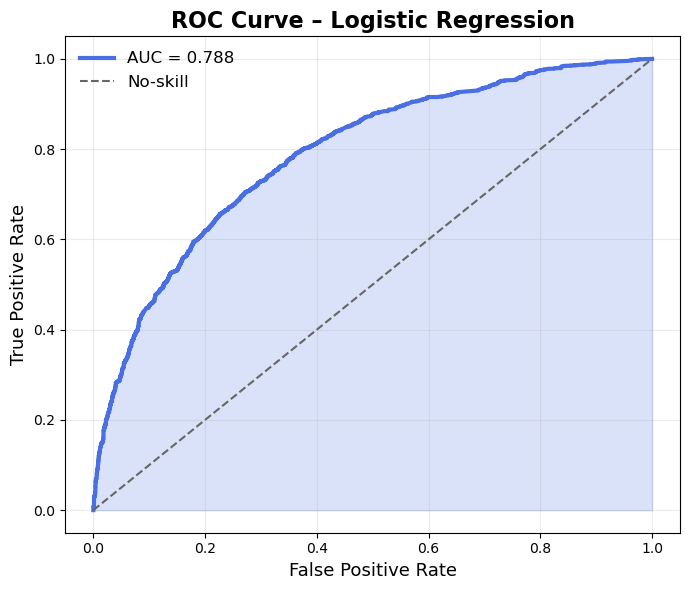

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=3, color="#4A6FE3", label=f"AUC = {auc:.3f}")

# Fill area under curve
plt.fill_between(fpr, tpr, alpha=0.2, color="#4A6FE3")

# No skill line
plt.plot([0,1],[0,1], linestyle="--", color="#666", label="No-skill")

# Styling
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("ROC Curve – Logistic Regression", fontsize=16, fontweight="bold")
plt.legend(frameon=False, fontsize=12)

plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
